In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
from scipy import stats

#### 1. Load the dataset

In [2]:
counts_df = pd.read_csv("counts.txt", sep="\t", index_col = 0)

coldata = pd.read_csv("sample-annotation.txt", sep="\t", index_col = 0)

gene_anno = pd.read_csv("gene-annotation.txt", sep="\t", index_col = 0)

In [3]:
print('counts_df:')
display(counts_df.head())
print('coldata:')
display(coldata.head())
print('gene_anno:')
display(gene_anno.head())

counts_df:


,SRR1146076,SRR1146077,SRR1146078,SRR1146079,SRR1146080,SRR1146081,SRR1146082,SRR1146083,SRR1146084,SRR1146085,...,SRR1146244,SRR1146245,SRR1146246,SRR1146247,SRR1146248,SRR1146249,SRR1146250,SRR1146252,SRR1146253,SRR1146254
ENSG00000000003,605,372,118,327,515,456,532,611,721,913,...,546,744,901,829,526,426,513,464,421,619
ENSG00000000005,254,7,33,10,60,19,76,10,44,52,...,25,55,57,51,28,66,55,45,13,37
ENSG00000000419,556,560,493,623,913,703,1996,1169,1407,903,...,706,659,933,784,599,630,709,698,903,1097
ENSG00000000457,530,376,184,604,407,516,721,570,711,864,...,572,596,523,590,547,594,707,457,309,563
ENSG00000000460,218,179,85,278,267,278,339,357,439,343,...,219,240,237,236,218,217,282,274,210,289


coldata:


,type
sample_id,
SRR1146076,normal
SRR1146077,lesional
SRR1146078,lesional
SRR1146079,lesional
SRR1146080,lesional


gene_anno:


,ENTREZID,SYMBOL,GENENAME
ENSEMBL,,,
ENSG00000000003,7105,TSPAN6,tetraspanin 6
ENSG00000000005,64102,TNMD,tenomodulin
ENSG00000000419,8813,DPM1,dolichyl-phosphate mannosyltransferase subunit...
ENSG00000000457,57147,SCYL3,SCY1 like pseudokinase 3
ENSG00000000460,55732,C1orf112,chromosome 1 open reading frame 112


In [4]:
print('counts_df shape :',counts_df.shape)
print('coldata shape: ',coldata.shape)
print('gene_anno shape: ',gene_anno.shape)

counts_df shape : (57992, 178)
coldata shape:  (178, 1)
gene_anno shape:  (25503, 3)


In [5]:
# Transforming the dataframe 
counts_df_t = counts_df.T

In [6]:
# Identify duplicated rows
duplicated_rows = counts_df_t.duplicated()

# Count the number of duplicated rows
num_duplicated_rows = duplicated_rows.sum()
print("Number of duplicated rows:", num_duplicated_rows)

Number of duplicated rows: 0


#### 2. Generate an object that contains the library-size normalized (CPM). 
for each feature 𝑖,
the CPM is the count of sequenced fragments mapping to the feature (the random
variable 𝑟𝑖 here) scaled by the total number of reads (𝑅) times one million (to bring it up to
a more convenient number)

In [7]:
# Calculate the total number of reads
total_reads = counts_df_t.sum(axis=0)

# Calculate the CPM values for each feature
cpm_df = 1e6 * (counts_df_t / total_reads) 

# Print the resulting dataframe of CPM values
cpm_df.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283690,ENSG00000283691,ENSG00000283692,ENSG00000283693,ENSG00000283694,ENSG00000283695,ENSG00000283696,ENSG00000283697,ENSG00000283698,ENSG00000283699
SRR1146076,4981.596911,18379.160637,3667.884897,4795.989467,4302.178718,4203.118127,9046.920317,6722.573491,4701.729406,6108.891748,...,NaN,10309.278351,0.000000,0.0,0.000000,0.0,10068.465566,4734.848485,60606.060606,0.0
SRR1146077,3063.064547,506.512301,3694.272558,3402.437810,3532.522892,7159.962856,1885.286261,3223.740485,3722.820444,4498.912888,...,NaN,0.000000,0.000000,0.0,0.000000,0.0,7652.033830,5681.818182,0.000000,0.0
SRR1146078,971.617249,2387.843705,3252.279234,1665.022758,1677.455005,9530.325986,800.735466,1358.269324,2740.203494,2520.294009,...,NaN,0.000000,0.000000,0.0,0.000000,0.0,805.477245,3472.222222,0.000000,0.0
SRR1146079,2692.532545,723.589001,4109.878221,5465.618185,5486.264604,8210.742388,3615.987227,4921.577140,4798.137107,6131.461545,...,NaN,5154.639175,0.000000,100000.0,0.000000,0.0,6443.817962,8207.070707,30303.030303,0.0
SRR1146080,4240.532907,4341.534009,6022.983653,3682.957949,5269.182191,4080.934461,5547.076539,5059.123400,4690.605440,5514.553757,...,NaN,5154.639175,58823.529412,0.0,166666.666667,0.0,3221.908981,5681.818182,0.000000,0.0


#### 4. Filter the count data for lowly-expressed genes

In [8]:
# Generate the list of samples for each group
group1_samples = coldata.index[coldata['type'] == 'normal'].tolist()
group2_samples = coldata.index[coldata['type'] == 'lesional'].tolist()

# Define the CPM and samples threshold
cpm_threshold = 1
samples_treshold = 0.75

# Initialize a list to store the filtered genes
filtered_genes = []

# Loop through each gene
for gene in cpm_df.columns:
    # Get the CPM values for this gene in each group
    group1_cpm = cpm_df.loc[group1_samples, gene]
    group2_cpm = cpm_df.loc[group2_samples, gene]

    # Check if the gene meets the filtering criteria
    if (sum(group1_cpm >= cpm_threshold) / len(group1_cpm) >= samples_treshold and
        sum(group2_cpm >= cpm_threshold) / len(group2_cpm) >= samples_treshold):
        filtered_genes.append(gene)

# Filter the expression data by the selected genes
filtered_data = cpm_df.loc[:, filtered_genes]

In [9]:
filtered_data.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283654,ENSG00000283657,ENSG00000283663,ENSG00000283667,ENSG00000283674,ENSG00000283683,ENSG00000283684,ENSG00000283689,ENSG00000283696,ENSG00000283697
SRR1146076,4981.596911,18379.160637,3667.884897,4795.989467,4302.178718,4203.118127,9046.920317,6722.573491,4701.729406,6108.891748,...,5593.536358,3571.428571,6036.596869,3317.172748,8115.471567,11230.907457,8100.147275,1290.322581,10068.465566,4734.848485
SRR1146077,3063.064547,506.512301,3694.272558,3402.437810,3532.522892,7159.962856,1885.286261,3223.740485,3722.820444,4498.912888,...,5593.536358,0.000000,7357.102434,5103.342689,1796.997276,449.236298,0.000000,12258.064516,7652.033830,5681.818182
SRR1146078,971.617249,2387.843705,3252.279234,1665.022758,1677.455005,9530.325986,800.735466,1358.269324,2740.203494,2520.294009,...,3729.024239,0.000000,9054.895303,2806.838479,10781.983653,0.000000,0.000000,4193.548387,805.477245,3472.222222
SRR1146079,2692.532545,723.589001,4109.878221,5465.618185,5486.264604,8210.742388,3615.987227,4921.577140,4798.137107,6131.461545,...,8079.552517,7142.857143,6791.171477,4082.674152,6724.247870,1796.945193,5891.016200,6451.612903,6443.817962,8207.070707
SRR1146080,4240.532907,4341.534009,6022.983653,3682.957949,5269.182191,4080.934461,5547.076539,5059.123400,4690.605440,5514.553757,...,3729.024239,4761.904762,3206.942086,7910.181169,2782.447394,5390.835580,4418.262150,5806.451613,3221.908981,5681.818182


####  4. Generate an object that contains the library-size normalized log-CPM data. 
Save it as a
binary file (.rda or .rds)

In [10]:
# Calculate the library sizes for each sample
library_sizes = filtered_data.sum(axis=0)

# Calculate the log-CPM values for each gene
logcpm_data = np.log2(filtered_data + 1)

# Normalize the log-CPM values by the library sizes
norm_data = logcpm_data.sub(np.log2(library_sizes + 1), axis=1)

# Save the data as a binary file
norm_data.to_pickle('norm_data.rda')


#### 5. Plots

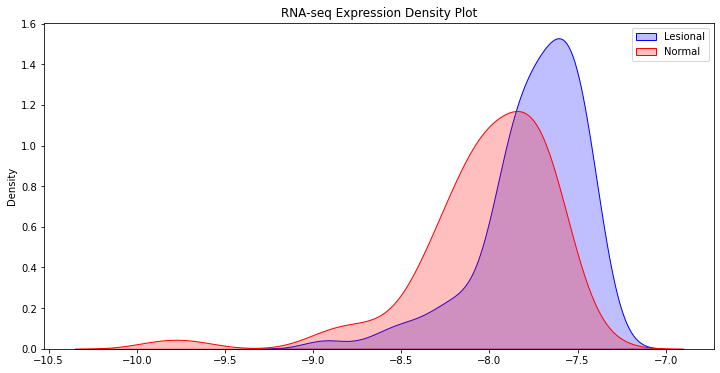

In [11]:
expression_df_normal = norm_data.loc[group1_samples, :]
expression_df_lesional = norm_data.loc[group2_samples, :]

fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(data=expression_df_normal.T.mean(), color='blue', shade=True, ax=ax)
sns.kdeplot(data=expression_df_lesional.T.mean(), color='red', shade=True, ax=ax)

plt.ylabel('Density')
plt.title('RNA-seq Expression Density Plot')
plt.legend(['Lesional', 'Normal'])

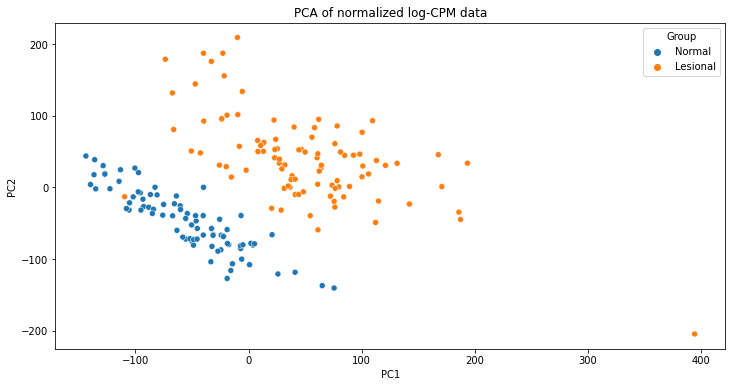

In [12]:
# Perform PCA on the normalized log-CPM data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_data)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index = filtered_data.index)
pca_df['Group'] = ['Normal' if s in group1_samples else 'Lesional' for s in pca_df.index]

# Plot the PCA results colored by group
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Group')
plt.title('PCA of normalized log-CPM data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### 6. Clean the data

In [13]:
# Identify the outlier/mis-labeled sample
mis_labeled = pca_df.index[(pca_df["PC1"] < -0.05) &(pca_df["PC2"] < 0) & (pca_df['Group']=='Lesional')]

In [14]:
# Remove the outlier/mis-labeled sample
norm_data = norm_data.drop(mis_labeled)
pca_df = pca_df.drop(mis_labeled)

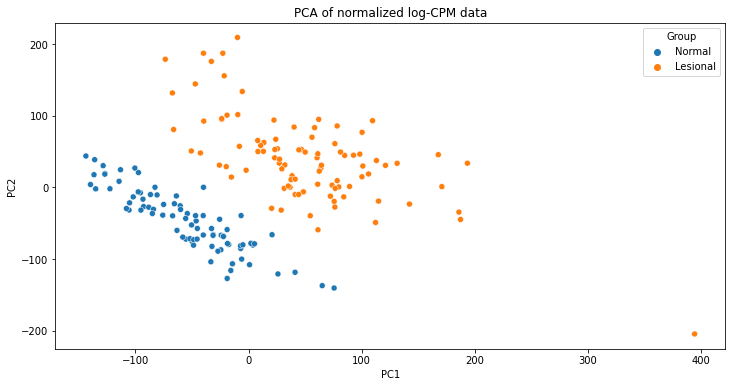

In [15]:
# Check if the outlier was removed
# Plot the PCA results colored by group
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Group')
plt.title('PCA of normalized log-CPM data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

The outlier was removed

In [16]:

# Calculate the interquartile range (IQR) for each gene
Q1 = norm_data.quantile(0.25)
Q3 = norm_data.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using Tukey's method
tukey_threshold = 1.5
outlier_mask = ((norm_data < (Q1 - tukey_threshold * IQR)) | (norm_data > (Q3 + tukey_threshold * IQR)))

# Set the outlier threshold to 25% of the total number of genes
outlier_threshold = int(0.25 * norm_data.shape[1])

# Count the number of outliers for each row (sample)
outlier_count = outlier_mask.sum(axis=1)

# Identify the rows (samples) where more than the outlier threshold number of genes are outliers
outlier_rows = outlier_count > outlier_threshold

# Remove the outlier rows from the RNA-seq data frame
rnaseq_df = norm_data[~outlier_rows]

# Print summary statistics
print("Initial shape of data frame: ", norm_data.shape)
print("Number of outliers removed: ", len(norm_data[outlier_rows]))
print("Final shape of data frame: ", rnaseq_df.shape)


Initial shape of data frame:  (177, 28836)
Number of outliers removed:  1
Final shape of data frame:  (176, 28836)


In [19]:
# Save the data as a binary file
rnaseq_df.to_pickle('norm_clean_data.rda')

It was aproved by Matan that my assigment will be evaluated based on the classification part and part one untill section 6